In [1]:
import sys
import os

SCRIPT_PATH = os.path.join(os.path.abspath(os.path.dirname('../__file__')), 'script')
sys.path.insert(0, SCRIPT_PATH)


from markov_pyactup import *
from statsmodels.formula.api import logit, glm
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)


main_dir = os.path.dirname(os.getcwd())
subject_dir = os.path.join(main_dir, 'data', 'human', 'online_data')
opt_dir = os.path.join(main_dir, 'data', 'model', 'param_optimization_0403')
#opt_dir = os.path.join(main_dir, 'data', 'model', 'old', 'param_optimization_0316')

main_dir, subject_dir, opt_dir

sns.set(font_scale=2)
sns.set_style("white")

Error trying to connect to ACT-R at 127.0.0.1 : 2651 with exception (<class 'ConnectionRefusedError'>, ConnectionRefusedError(111, 'Connection refused'), <traceback object at 0x7f2c6012c6c0>)
ACT-R connection NOT established, but no exception detected or already handled.
Could not start ACT-R connection.


## Correlation of `alpha`

Next, let's look at whether two alpha is correlated in two hybrid models. 

We found alpha, bet_mf, lambda, p are significantly correlated between two models

In [2]:
df1 = MarkovEstimation.load_optimization_data(opt_dir=opt_dir, estimate_models=['markov-rl-hybrid'], only_maxLL=1).melt(id_vars=['subject_id', 'estimate_model'], var_name='param_name', value_name='param_value')
df2 = MarkovEstimation.load_optimization_data(opt_dir=opt_dir, estimate_models=['markov-ibl-hybrid'], only_maxLL=1).melt(id_vars=['subject_id', 'estimate_model'], var_name='param_name', value_name='param_value')
dfm = pd.merge(df1.drop(columns=['estimate_model']), df2.drop(columns=['estimate_model']), on=['subject_id', 'param_name'], suffixes=('.rl', '.actr'))
dfm.head()

,subject_id,param_name,param_value.rl,param_value.actr
0,1,alpha,1.0000,0.9320
1,2,alpha,0.9459,0.5590
2,3,alpha,0.0090,0.5800
3,4,alpha,0.0546,0.0300
4,5,alpha,0.3763,0.3755


In [3]:
print( 'NUM SUBJ [%d]' % (len(dfm['subject_id'].unique())))

NUM SUBJ [151]


## Distribution of parameters 

### RL

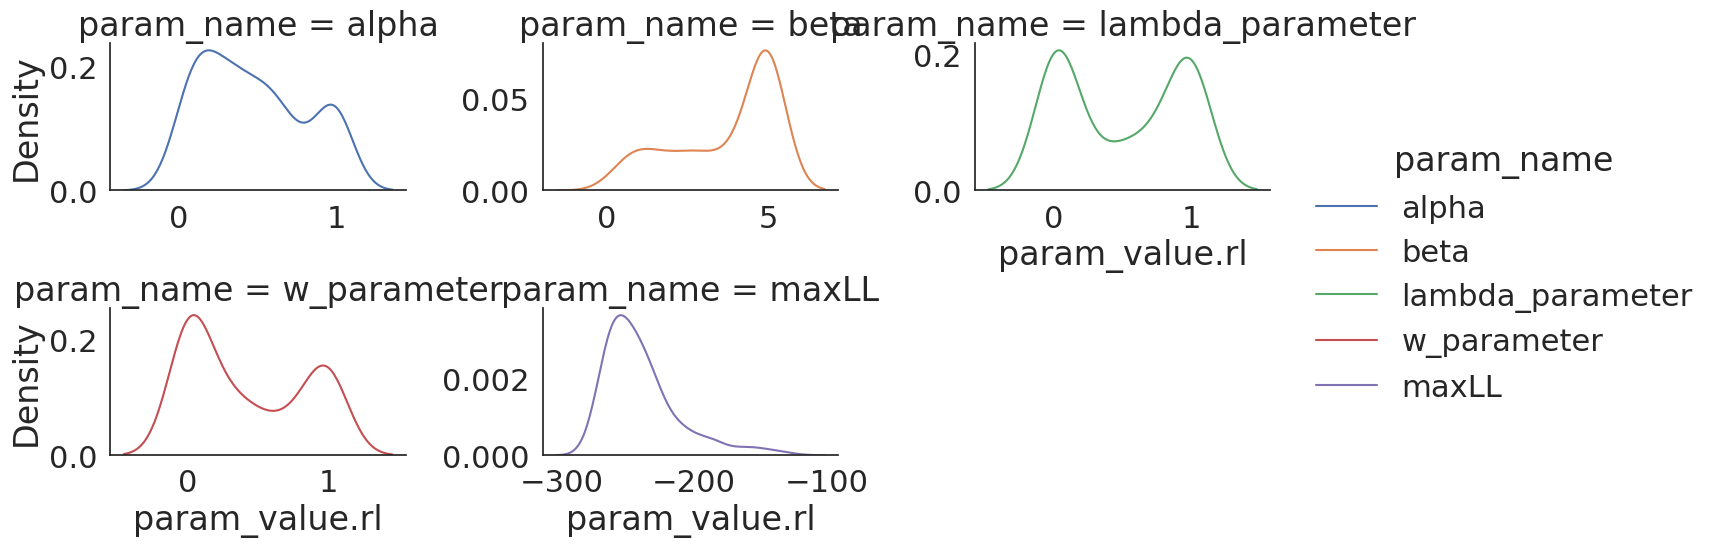

In [4]:
g = sns.displot(data=dfm[~dfm['param_name'].isin(['p_parameter', 'lf', 'fixed_cost', 'temperature', 'decay'])], x="param_value.rl", hue="param_name", warn_singular=False, 
                col="param_name", col_wrap=3, height=3, aspect=1.5,
                kind="kde", facet_kws=dict(sharey=False, sharex=False))
# sns.move_legend(g, "upper left", ncol=1, title='parameter names', frameon=False, bbox_to_anchor=(1,1))

### IBL

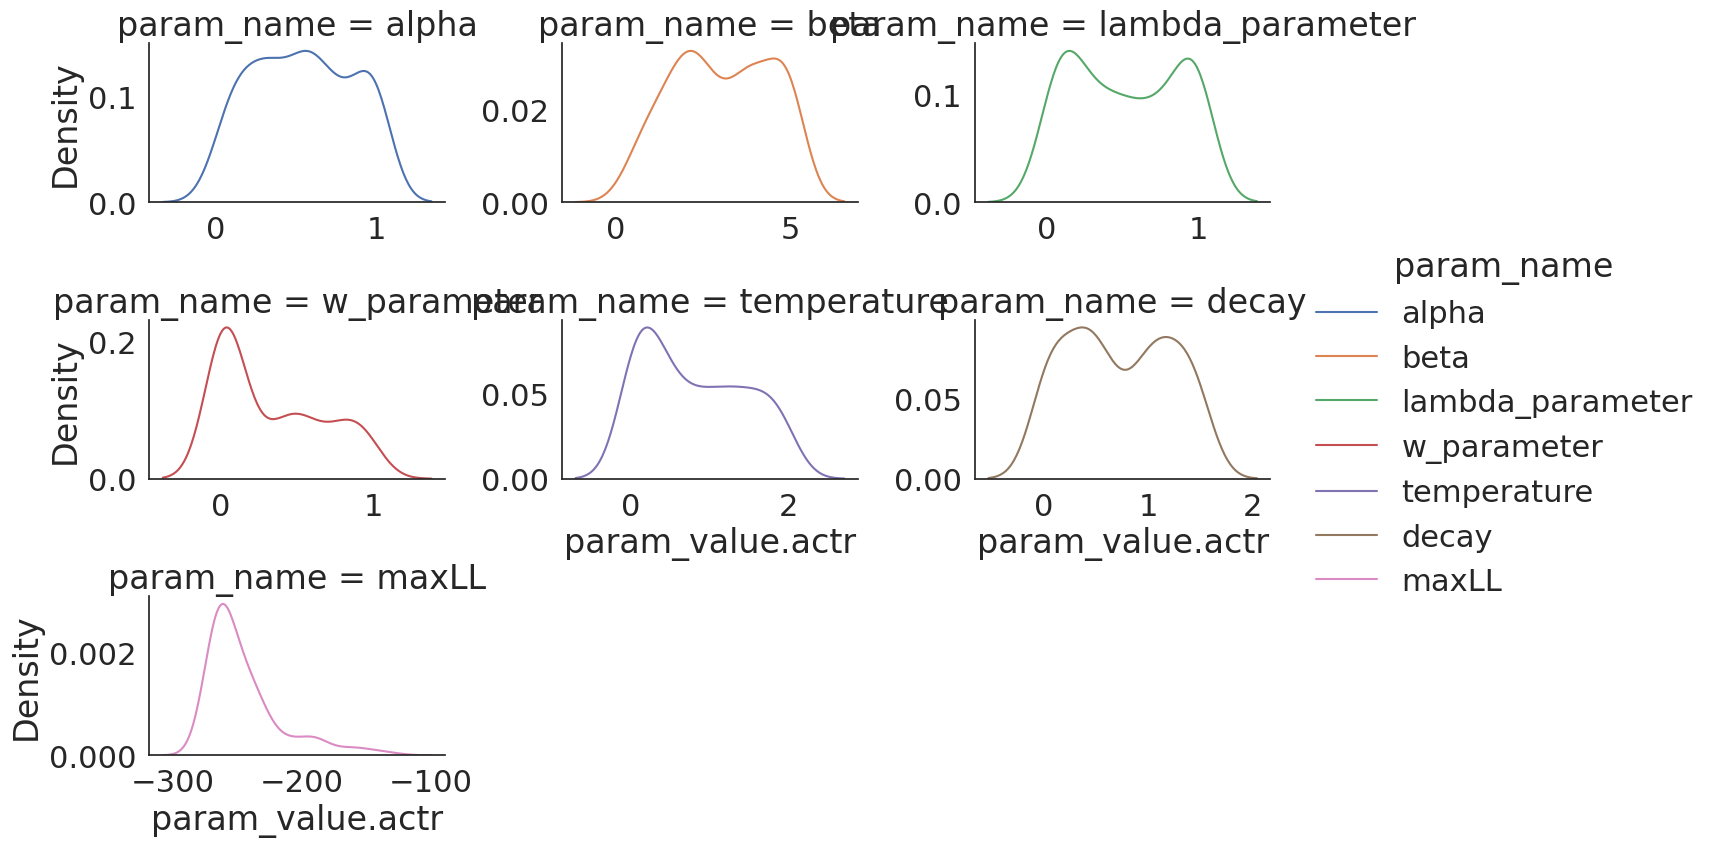

In [5]:
g = sns.displot(data=dfm[~dfm['param_name'].isin(['p_parameter', 'lf', 'fixed_cost'])], x="param_value.actr", hue="param_name", warn_singular=False, 
                col="param_name", col_wrap=3, height=3, aspect=1.5,
                kind="kde", facet_kws=dict(sharey=False, sharex=False))

In [6]:
dfm.groupby(['param_name']).agg(rl_mean = ('param_value.rl', 'mean'), 
                               rl_sd = ('param_value.rl', 'std'), 
                               ibl_mean = ('param_value.actr', 'mean'),
                               ibl_sd = ('param_value.actr', 'std')).round(2).reset_index()

,param_name,rl_mean,rl_sd,ibl_mean,ibl_sd
0,alpha,0.47,0.33,0.54,0.31
1,beta,3.70,1.59,3.03,1.39
2,decay,0.50,0.00,0.72,0.49
3,fixed_cost,0.00,0.00,0.00,0.00
4,lambda_parameter,0.50,0.43,0.52,0.35
5,lf,0.50,0.00,0.50,0.00
6,maxLL,-239.90,27.84,-245.00,28.99
7,p_parameter,0.00,0.00,0.00,0.00
8,temperature,0.20,0.00,0.82,0.65
9,w_parameter,0.42,0.41,0.33,0.34


## Correlation of parameter sets between IBL vs. RL

In [7]:
dfm = dfm.rename(columns={'param_value.rl':'Pure RL Model', 'param_value.actr':'Hybrid ACT-R Model'})
dfm = dfm.replace('lambda_parameter', 'lambda')

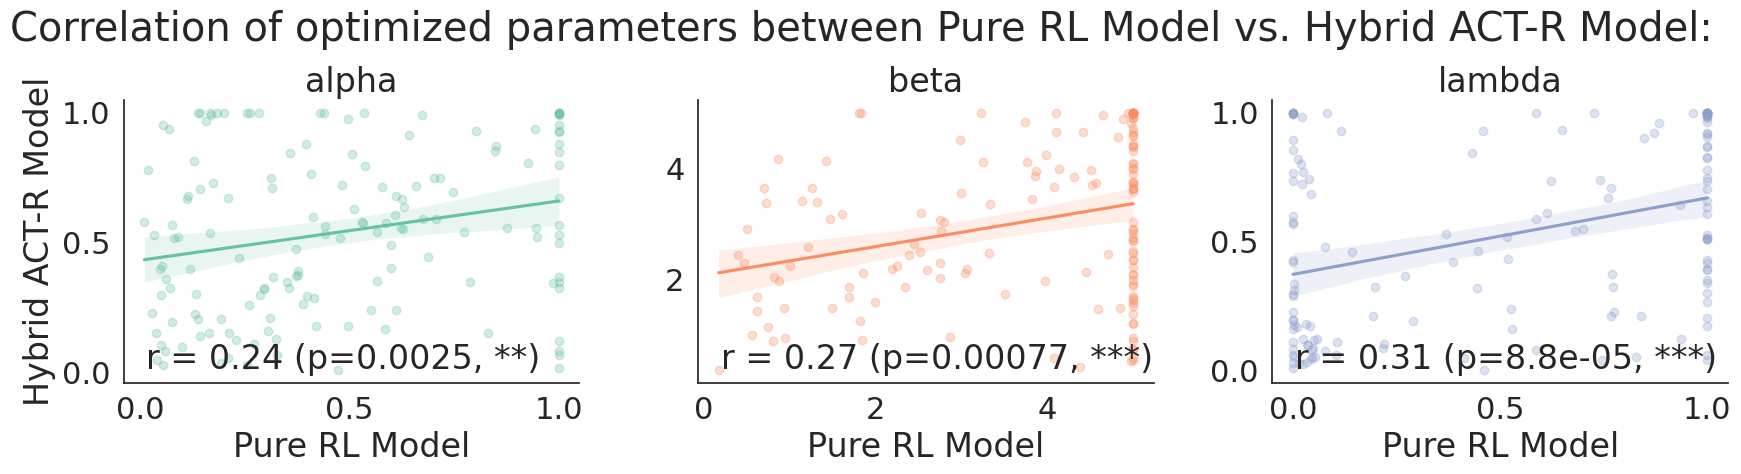

In [8]:
MarkovPlot.parameter_lm_plot(df=dfm, x_name="Pure RL Model", y_name="Hybrid ACT-R Model",  
                             exclude_parameters=['maxLL', 
                                                 'temperature', 
                                                 'decay', 
                                                 'w_parameter', 
                                                 'p_parameter', 
                                                 'lf', 
                                                 'fixed_cost',
                                                 'init'], alpha=0.3)

## Correlation of Age and Parameters

### Age vs. RL

In [9]:
dfa = pd.read_csv(os.path.join(subject_dir, 'mbmf_ages.csv'))
dfa['subject_id'] = dfa['subject_id'].apply(lambda x: int(x[3:]))

dfa = pd.merge(dfm, dfa, on='subject_id', how='left') 

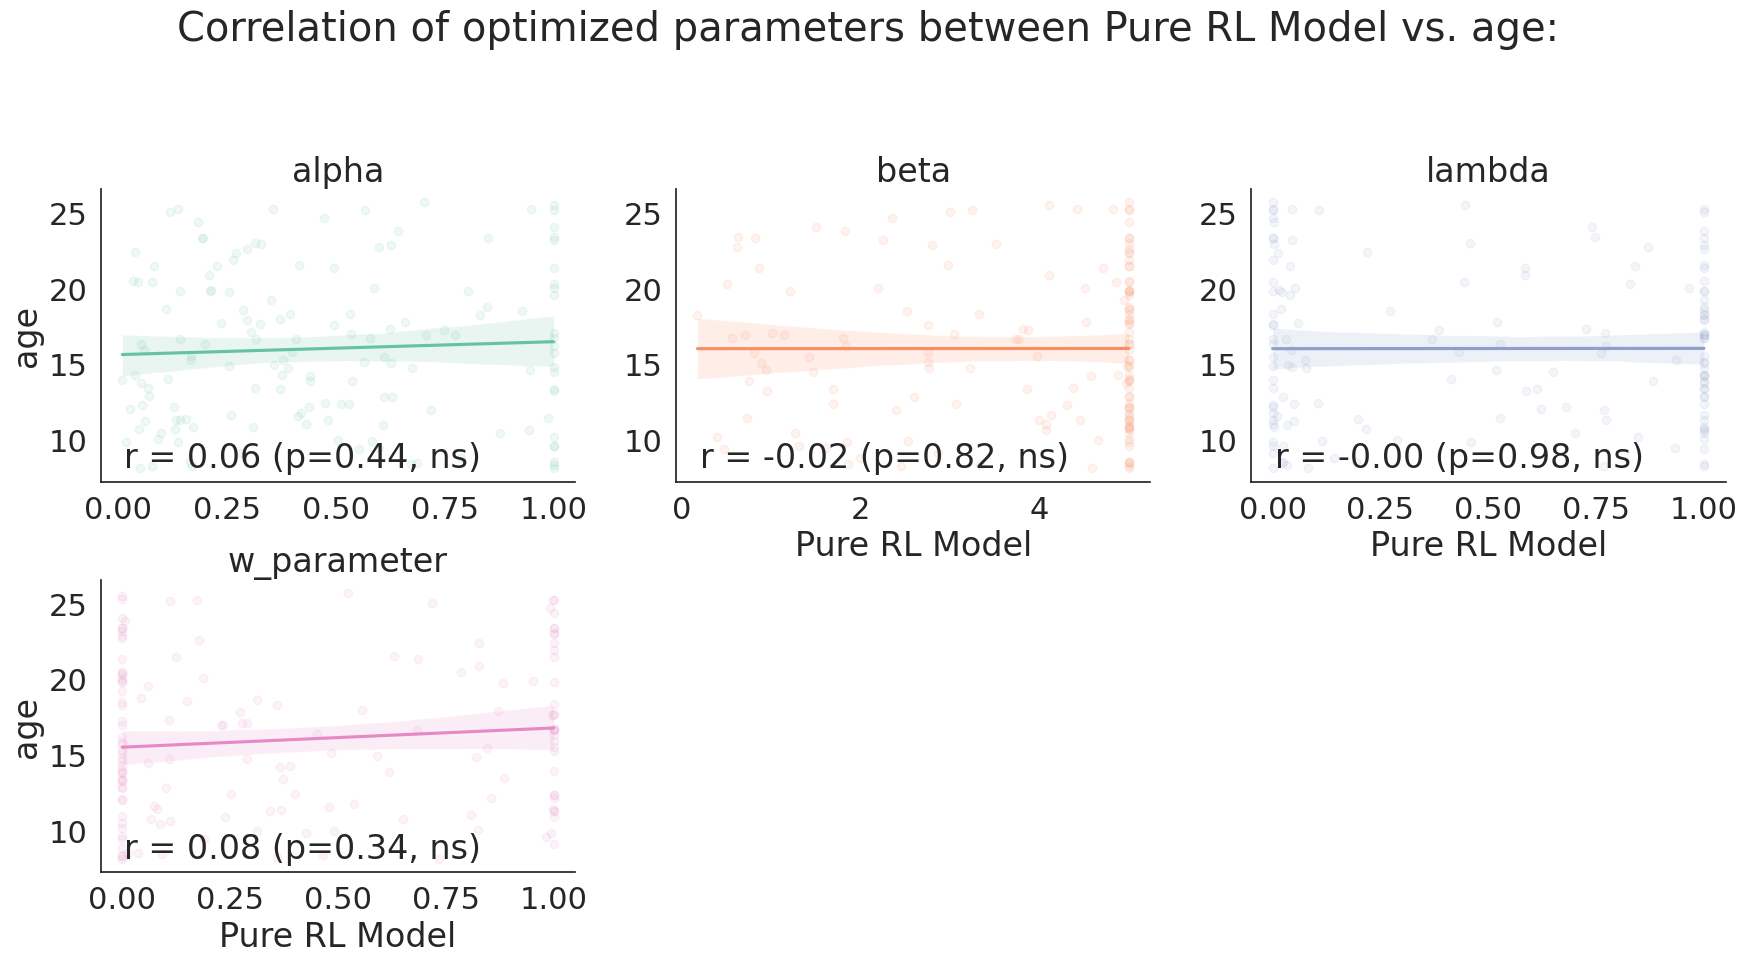

In [11]:
MarkovPlot.parameter_lm_plot(df=dfa, y_name="age", x_name="Pure RL Model", 
                             exclude_parameters=['p_parameter', 'temperature', 'decay', 'lf', 'fixed_cost', 'maxLL'])

### Correlation of Age and IBL

In [12]:
dfa.head()

,subject_id,param_name,Pure RL Model,Hybrid ACT-R Model,gender,age
0,1,alpha,1.0000,0.9320,Female,17.055556
1,2,alpha,0.9459,0.5590,Female,14.575000
2,3,alpha,0.0090,0.5800,Male,13.919444
3,4,alpha,0.0546,0.0300,Male,12.297222
4,5,alpha,0.3763,0.3755,Male,14.238889


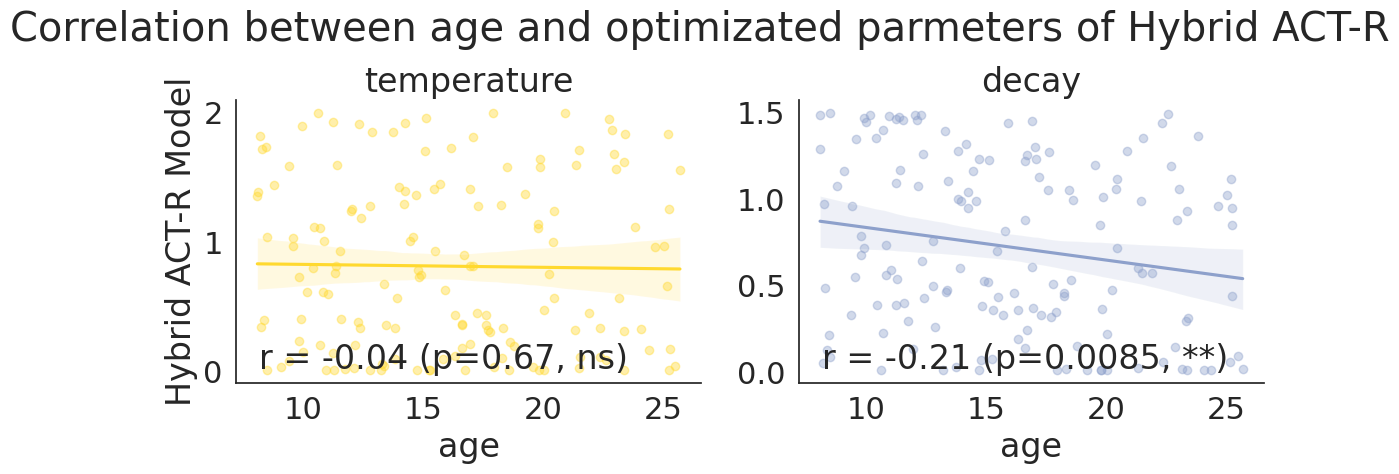

In [18]:
# MarkovPlot.parameter_lm_plot(df=dfa, x_name="age", y_name="param_value.ibl",  exclude_parameters=['alpha', 'beta', 'lambda_parameter', 'w_parameter', 'p_parameter', 'lf', 'fixed_cost', 'maxLL'])
g = sns.lmplot(data=dfa[dfa['param_name'].isin(['temperature', 'decay'])], 
               x='age', y='Hybrid ACT-R Model',
               col="param_name", hue="param_name",
               height=5, aspect=1.2, palette='Set2_r',
               scatter_kws={'alpha': 0.4},
               facet_kws=dict(sharex=False, sharey=False))
g.map_dataframe(MarkovPlot.annotate, x='age', y='Hybrid ACT-R Model')
g.fig.subplots_adjust(top=.8)  
g.set_titles(col_template="{col_name}")
g.fig.suptitle('Correlation between age and optimizated parmeters of Hybrid ACT-R')
plt.show()

## Age Group



In [ ]:
dfa.loc[dfa['age'] <= 12.00, 'age_group'] = 'children'
dfa.loc[(dfa['age'] > 12.00) & (dfa['age'] <= 17.00), 'age_group'] = 'adolescent'
dfa.loc[dfa['age'] > 17.00, 'age_group'] = 'adult'

np.unique(dfa[['subject_id', 'age_group']].drop_duplicates()['age_group'], return_counts=True)

In [ ]:
MarkovPlot.parameter_lm_plot(df=dfa.loc[dfa['age_group'] == 'children',:], x_name="age", y_name="param_value.actr",  exclude_parameters=['lf', 'fixed_cost'])
MarkovPlot.parameter_lm_plot(df=dfa.loc[dfa['age_group'] == 'adolescent',:], x_name="age", y_name="param_value.actr",  exclude_parameters=['lf', 'fixed_cost'])
MarkovPlot.parameter_lm_plot(df=dfa.loc[dfa['age_group'] == 'adult',:], x_name="age", y_name="param_value.actr",  exclude_parameters=['lf', 'fixed_cost'])

## Exclude Outliers

Unfortunately, excluding lowest 5% maxLL subjects does not help

In [ ]:
ax = sns.displot(data=dfa[dfa['param_name']=='maxLL'], x='param_value.actr', hue='age_group', kind='kde')

In [ ]:
cut = dfa[dfa['param_name']=='maxLL']['param_value.actr'].describe(percentiles=[.05, .5, .95])['5%']
drop_subjects = dfa[(dfa['param_name']=='maxLL') & (dfa['param_value.actr']<=cut)]['subject_id'].unique()
drop_subjects

In [ ]:
dfaa = dfa[~dfa['subject_id'].isin(drop_subjects)]

MarkovPlot.parameter_lm_plot(df=dfaa.loc[dfaa['age_group'] == 'children',:], x_name="age", y_name="param_value.actr",  exclude_parameters=['lf', 'fixed_cost'])
MarkovPlot.parameter_lm_plot(df=dfaa.loc[dfaa['age_group'] == 'adolescent',:], x_name="age", y_name="param_value.actr",  exclude_parameters=['lf', 'fixed_cost'])
MarkovPlot.parameter_lm_plot(df=dfaa.loc[dfaa['age_group'] == 'adult',:], x_name="age", y_name="param_value.actr",  exclude_parameters=['lf', 'fixed_cost'])

In [ ]:
from scipy.stats import shapiro 
from statsmodels.graphics.gofplots import qqplot
 
var_name = 'age'
stat, p = shapiro(dfa[var_name]) 
 
qqplot(dfa[var_name], line='s')
plt.title('Normality Check: [%s] (p = %.2f)' %(var_name, p))
plt.show()